In [34]:
from pathlib import Path
import pandas as pd
from matplotlib_venn import venn2
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import pingouin
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse

mpl.rc('font',family='Arial')

df = pd.read_csv("final_filter_invoked_methods.tsv.zip", sep='\t', header=0)
df_cut = pd.read_csv("cut_access_modifiers_type.csv",header=0)

In [47]:
#get shared elements for each combination of sets
def get_shared(sets):
    IDs = sets.keys()
    combs = sum([list(map(list, combinations(IDs, i))) for i in range(1, len(IDs) + 1)], [])

    shared = {}
    for comb in combs:
        ID = ' and '.join(comb)
        if len(comb) == 1:
            shared.update({ID: sets[comb[0]]})
        else:
            setlist = [sets[c] for c in comb]
            u = set.intersection(*setlist)
            shared.update({ID: u})
    return shared


#get unique elements for each combination of sets
def get_unique(shared):
    unique = {}
    for shar in shared:
        if shar == list(shared.keys())[-1]:
            s = shared[shar]
            unique.update({shar: s})
            continue
        count = shar.count(' and ')
        if count == 0:
            setlist = [shared[k] for k in shared.keys() if k != shar and " and " not in k]
            s = shared[shar].difference(*setlist)
        else:
            setlist = [shared[k] for k in shared.keys() if k != shar and k.count(' and ') >= count]
            s = shared[shar].difference(*setlist)
        unique.update({shar: s})
    return(unique)


#plot Venn
def venny4py2(sets={}, out='./', asax=False, ext='png', dpi=300, size=3.5):
    shared = get_shared(sets)
    unique = get_unique(shared)
    ce = 'bgrc' #colors
    lw = size*.12 #line width
    fs = size*2.2 #font size
    nc = 2 #legend cols
    cs = 4 #columnspacing
    
    with open(f'{out}/Intersections_{len(sets)}.txt', 'w') as f:
        for k, v in unique.items():
            f.write(f'{k}: {len(v)}, {sorted(list(v))}\n')
    
    if asax == False:
        plt.rcParams['figure.dpi'] = 200 #dpi in notebook
        plt.rcParams['savefig.dpi'] = dpi #dpi in saved figure
        fig, ax = plt.subplots(figsize=(1, 1))

    else:
        ax = asax
        
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.axis('off')
    #4 sets
    if len(sets) == 4:
        #draw ellipses
        ew = 45 #width
        eh = 75 #height
        xe = [35, 48, 52, 65] #x coordinats
        ye = [35, 45, 45, 35] #y coordinats
        ae = [225, 225, 315, 315] #angles

        for i, s in enumerate(sets):
            ax.add_artist(Ellipse(xy=(xe[i], ye[i]), width=ew, height=eh, fc=ce[i], 
                                  angle=ae[i], alpha=1-((i+3)/10+0.2)))
            ax.add_artist(Ellipse(xy=(xe[i], ye[i]), width=ew, height=eh, fc='None',
                                  angle=ae[i], ec='black', lw=lw))

        #annotate
        xt = [12, 32, 68, 88, 14, 34, 66, 86, 26, 28, 50, 50, 72, 74, 37, 60.5, 39.5, 63, 50] #x
        yt = [67, 79, 79, 67, 41, 70, 70, 41, 59, 26, 11, 60, 26, 59, 51, 18.5, 18.5, 51, 35] #y
        
        _xt = [11, 32, 68, 90]
        _yt = [20, 79, 79, 20]
        
        
        for j, s in enumerate(sets):
            ax.text(_xt[j], _yt[j], s + "", ha='center', va='center', fontsize=15, 
                    transform=ax.transData,fontweight='bold')

        for k in unique:
            j += 1
            result_float = len(unique[k]) / 4816 * 100
            result_str = "{:.2f}".format(result_float).rstrip('0').rstrip('.') if '.' in str(result_float) else str(result_float)
            ax.text(xt[j], yt[j], str(len(unique[k])) + "\n(" + result_str + "%)", ha='center', va='center', fontsize=fs, 
                    transform=ax.transData)

    handles = [mpatches.Patch(color=ce[i], label=l, alpha=0) for i, l in enumerate(sets)]
    plt.text(28, 0, 'Number of Projects: ' + str(len(result)), fontsize = 15,fontweight='bold')
    if asax == False:
        fig.savefig(f'{out}/Venn_{len(sets)}.{ext}', bbox_inches='tight', facecolor='w', )

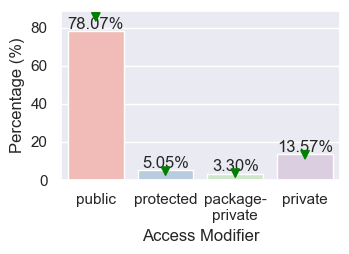

In [4]:
_cut_type_modifiers_df = pd.read_csv('cut_access_modifiers_percentage.csv',low_memory=False)
length = len(_cut_type_modifiers_df)
_percentage_cut_type_modifiers_df = pd.DataFrame({'Access Modifier': ['public', 'protected', 'package-\nprivate', 'private'], 
                                                  'Percentage (%)': [_cut_type_modifiers_df['public_percentage'].sum()/length, _cut_type_modifiers_df['protected_percentage'].sum()/length,
                                                           _cut_type_modifiers_df['package-private_percentage'].sum()/length,_cut_type_modifiers_df['private_percentage'].sum()/length],
                                                'Median': [82.05128151,1.041667071,0,9.65147404]})
# who v/s fare barplot
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(3.6, 2.2))
g = sns.barplot(x = 'Access Modifier',y = 'Percentage (%)',data = _percentage_cut_type_modifiers_df, palette="Pastel1")
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height() + "%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

for i, median in enumerate(_percentage_cut_type_modifiers_df['Median']):
    ax.annotate(f'', (i, median), ha='center', va='bottom', color='red', xytext=(0, 10),
                textcoords='offset points', arrowprops=dict(arrowstyle='simple', color='green'))


_ = g.set_ylim(0,89) #To make space for the annotations
# Show the plot
plt.show()

DESCRIPTION:
            # Tests
count  4801.000000
mean     47.264112
std     147.665281
min       1.000000
25%       4.000000
50%      13.000000
75%      40.000000
max    5249.000000


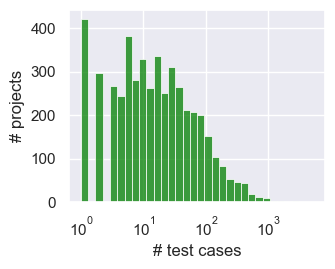

In [10]:
project_test_count_df = df.groupby(['Project', 'Test Case']).size().reset_index(name='count').groupby(['Project']).size().reset_index(name='count')
project_test_count_df.columns = ['Project', '# Tests']
print('DESCRIPTION:\n',project_test_count_df.describe())
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(3.3, 2.5))
sns.histplot(
    data=project_test_count_df, x="# Tests", log_scale=True,color="green").set(
    xlabel='# test cases', 
    ylabel='# projects',
)
plt.show()

In [16]:
result = df.pivot_table(index='Project', columns='Access Modifier', values='count_y', aggfunc='count', fill_value=0)
print(result)
print(result['Public'].sum(axis=0))
print(result['Protected'].sum(axis=0))
print(result['Package'].sum(axis=0))
print(result['Private'].sum(axis=0))

Access Modifier                       Package  Private  Protected  Public
Project                                                                  
01org-jndn-management                       0        0          0     136
10Duke-event-api                            0        0          0       2
1337joe-cubesensors-for-java                0        0          0      10
1and1-bill-of-materials-maven-plugin        7        0          0       7
1and1-spritepacker-maven-plugin             6        0         29      77
...                                       ...      ...        ...     ...
zulily-dropship                             2        0          0       1
zulkar-russian-translit                     0        0          0       3
zxl0714-leveldb-sstable                     0        0          0     110
zxl0714-redis-mock                          0        0          0     154
zyndev-fastsql                              0        0          0       5

[4801 rows x 4 columns]
789455
9592
1

In [32]:
print("# unique invoked")
df.groupby(['Project','Method Name','Access Modifier']).size().reset_index(name="Count").groupby("Access Modifier").size().reset_index(name="Count")

# unique invoked


,Access Modifier,Count
0,Package,4243
1,Private,118
2,Protected,2601
3,Public,179640


In [40]:
df_projects = set(df["Project"])
df_cut = df_cut[df_cut["project"].isin(df_projects)]
print(df_cut.sum(axis=0))

Unnamed: 0                                                               11702755
project                         antkorwin-mimetyperfksystems-commandersomosdig...
CtMethodImpl_protected                                                      70579
CtMethodImpl_package-private                                                27459
CtMethodImpl_public                                                       1468185
CtMethodImpl_private                                                       132701
dtype: object


In [33]:
print('# method invoked')
df.groupby(['Project','Internal Test Case','Method Name','Access Modifier']).size().reset_index(name="Count").groupby("Access Modifier").size().reset_index(name="Count")

# method invoked


,Access Modifier,Count
0,Package,10574
1,Private,178
2,Protected,6713
3,Public,554833


In [50]:
print('Public',df_cut[df_cut['project'].isin(set(df['Project']))]["CtMethodImpl_public"].sum())
print('Protected',df_cut[df_cut['project'].isin(set(df['Project']))]["CtMethodImpl_protected"].sum())
print('Package-private',df_cut[df_cut['project'].isin(set(df['Project']))]["CtMethodImpl_package-private"].sum())
print('Private',df_cut[df_cut['project'].isin(set(df['Project']))]["CtMethodImpl_private"].sum())
print(df_cut[df_cut['project'].isin(set(df['Project']))].to_csv("/Desktop/cut_access_modifiers_type.csv"))
print(df.groupby(['Project','Method Name','Access Modifier']).size().reset_index(name='count').groupby(['Access Modifier']).size().reset_index(name='count'))

public = 179640/df_cut[df_cut['project'].isin(set(df['Project']))]["CtMethodImpl_public"].sum() * 100
protected = 2601/df_cut[df_cut['project'].isin(set(df['Project']))]["CtMethodImpl_protected"].sum() * 100
package_private = 4243/df_cut[df_cut['project'].isin(set(df['Project']))]["CtMethodImpl_package-private"].sum() * 100
private = 118/df_cut[df_cut['project'].isin(set(df['Project']))]["CtMethodImpl_private"].sum() * 100

print('public:',public)
print('protected:',protected)
print('package-private:',package_private)
print('private:',private)

Public 1468185
Protected 70579
Package-private 27459
Private 132701
None
  Access Modifier   count
0         Package    4243
1         Private     118
2       Protected    2601
3          Public  179640
public: 12.235515279069055
protected: 3.6852321512064496
package-private: 15.452128628136494
private: 0.08892171121543922


ValueError: The log base cannot be <= 0 or == 1

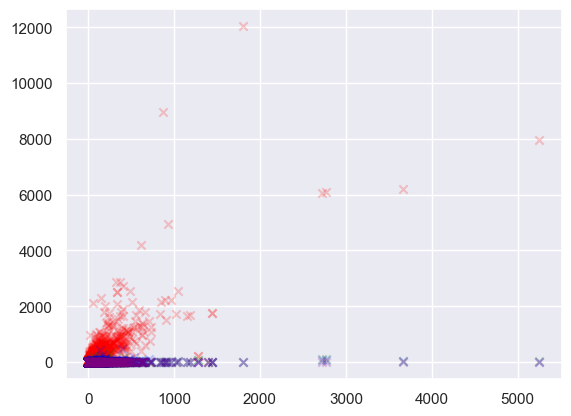

In [59]:
projects_df = df
access_modifier_df = projects_df.groupby(['Project','Access Modifier','Internal Test Case','Method Name']).size().reset_index(name='count').groupby(['Project','Access Modifier']).size().reset_index(name='count').pivot(index='Project', columns='Access Modifier', values='count').reset_index().fillna(0)
num_of_tests_df = projects_df.groupby(['Project','Test Case']).size().reset_index(name='count').groupby('Project').size().reset_index(name='numOfTests')
_projects_df = pd.merge(access_modifier_df, num_of_tests_df, how='inner', on=['Project'])

plt.scatter(_projects_df['numOfTests'], _projects_df['Public'], label='Public', color='red', alpha=0.2, marker='x')
plt.scatter( _projects_df['numOfTests'], _projects_df['Protected'], label='Protected', color='green', alpha=0.2, marker='x')
plt.scatter(_projects_df['numOfTests'], _projects_df['Package'], label='Package', color='blue', alpha=0.2, marker='x')
plt.scatter(_projects_df['numOfTests'], _projects_df['Private'], label='Private', color='purple', alpha=0.2, marker='x')
plt.xscale('log', base=1)
plt.yscale('log', base=1)

plt.xlabel('Number of Tests')
plt.ylabel('Number of Invocation')

plt.legend()
plt.show()

(0.0, 78.0)

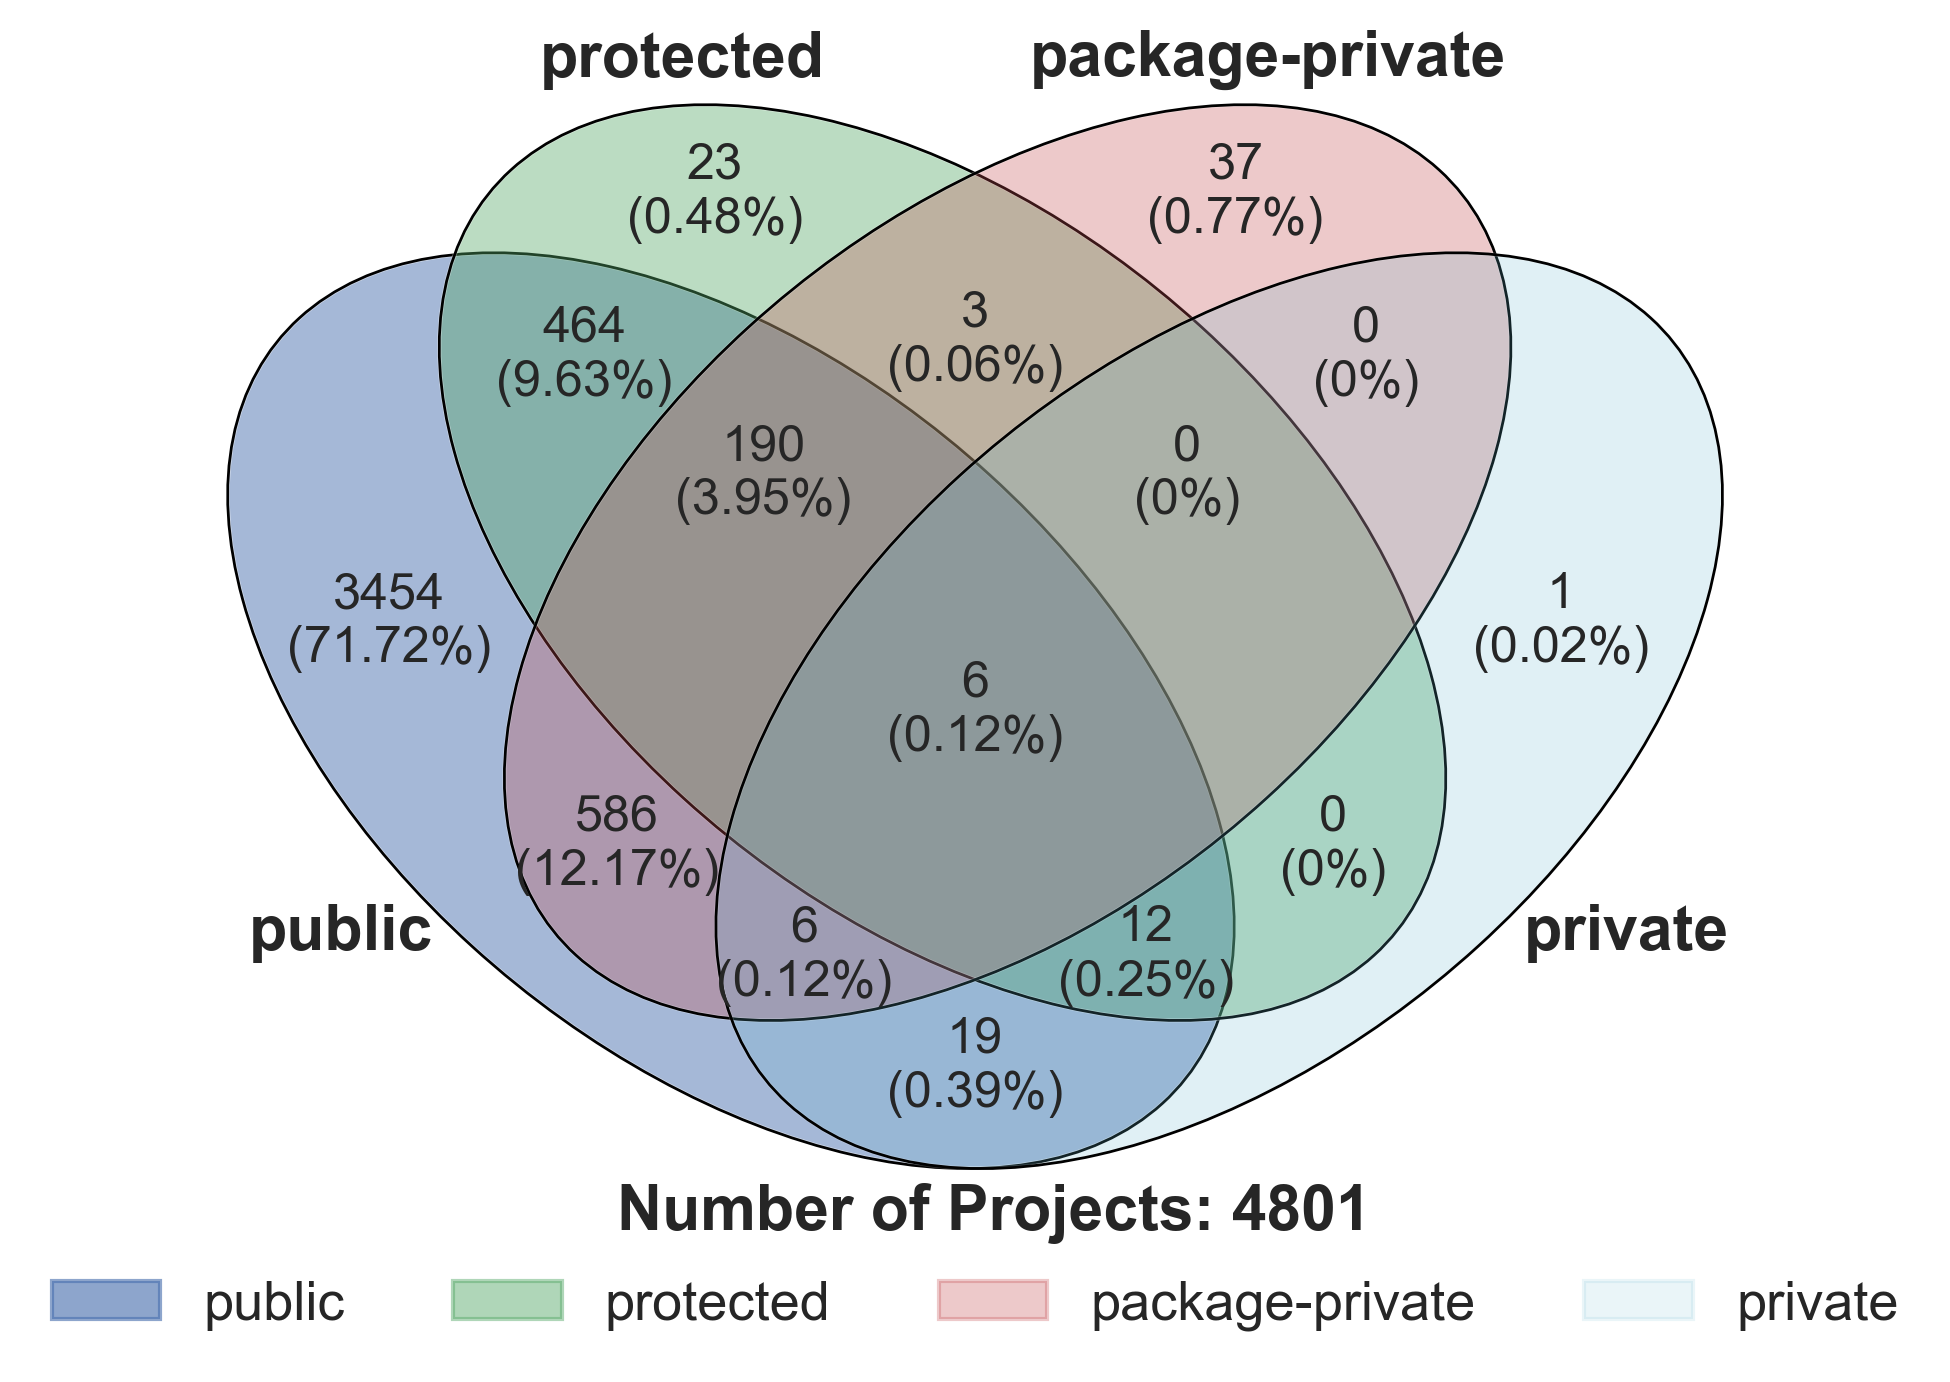

In [48]:
result = df.pivot_table(index='Project', columns='Access Modifier', values='count_y', aggfunc='count', fill_value=0)
# If you want to reset the index
result = result.reset_index()
private_set = set(result[result["Private"] > 0].index)
public_set = set(result[result["Public"] > 0].index)
package_set = set(result[result["Package"] > 0].index)
protected_set = set(result[result["Protected"] > 0].index)
non_public_set = set(result[(result["Protected"] > 0) | (result["Package"] > 0) | (result["Private"] > 0)].index)

# Create a Venn diagram
sets = {
    'public': public_set,
    'protected': protected_set,
    'package-private': package_set,
    'private': private_set}
fig, ax = plt.subplots(figsize=(7, 5), dpi=300)
venny4py2(sets=sets, size=5.5, asax=ax)

ce='bgrc' 
ax.legend(loc='lower center', labels=sets, handles=[mpatches.Patch(color=ce[i], label=l, alpha=1-((i+1)/6+0.2)) for i, l in enumerate(sets)], fontsize=13, frameon=False, bbox_to_anchor=(.5, -.13), ncol=4)
ax.set_ylim(0, 78)